## Documentation
Requirements:

get keras-segmentation with 'pip install keras-segmentation'. Refer to documentation https://github.com/divamgupta/image-segmentation-keras

Useful tutorials:

https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html


Directory structure:
TODO

### Handseg dataset:
Width: 640, Height: 480. The annotated images contain three classes: background: 0, right_hand: 1, left_hand: 2.

Accessing the data:

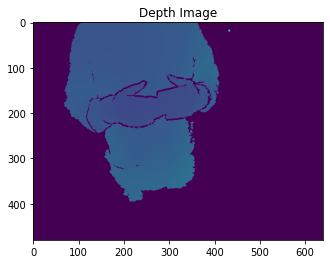

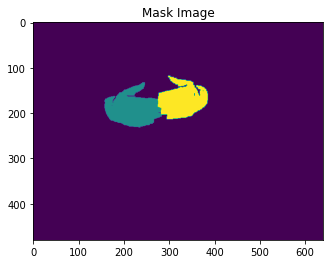

1


In [18]:
#path to the dataset
handseg_path = '../../handseg-150k'
depth_im = np.array(Image.open(Path(handseg_path+'/images/user-2.00000000.png')))# Loading depth image
mask_im = np.array(Image.open(Path(handseg_path+'/masks/user-2.00000000.png')))#  Loading mask image
depth_im = depth_im.astype(np.float32)# Converting to float
mean_depth_ims = 10000.0 # Mean value of the depth images
depth_im /= mean_depth_ims # Normalizing depth image
plt.imshow(depth_im); plt.title('Depth Image'); plt.show() # Displaying Depth Image
plt.imshow(mask_im); plt.title('Mask Image'); plt.show() # Displaying Mask Image

print(mask_im[200,200])

In [1]:
# Library header
from PIL import Image
from matplotlib import pyplot as plt
from pathlib import Path
from tensorflow.keras import Model, Input
from tqdm import tqdm
import shutil #library for moving files
import tensorflow as tf
import numpy as np
import cv2

# own libraries
import split_dataset as spData
import handseg_model as hand
import data_gen as dg


#globals
input_width = 640
input_height = 480
handseg_path = '../../../handseg-150k'

In [1]:
test_path = '../../../test'
depth_im = np.array(tf_keras_prep.image.load_img(test_path+"/image/user-3.00025727.png", color_mode='grayscale'))
mask_im = np.array(tf_keras_prep.image.load_img(test_path+"/mask/user-3.00025727.png", color_mode='grayscale'))

# do some preprocessing
depth_gray = ( depth_im /depth_im.max() )

print(depth_im.shape, depth_im.min(), depth_im.max())
print(depth_gray.shape, depth_gray.min(), depth_gray.max())


plt.imshow(depth_im); plt.title('Depth Image'); plt.show() # Displaying Depth Image
plt.imshow(depth_gray, cmap="gray"); plt.title('Grayscale Image'); plt.show() # Displaying Grayscale Image
plt.imshow(mask_im); plt.title('Mask Image'); plt.show() # Displaying Mask Image

NameError: name 'np' is not defined

In [7]:
# create the validation split
# ATTENTION: only execute this method once, since the files in the directory will be changed permanently
#spData.createValidationSplit()

In [2]:
# preprocessing
def preprocess(img):
    return (img / img.max()) * 255

# create the data generators with data_loader
# ... for training
train_gen = dg.image_segmentation_generator(
        images_path=handseg_path+"/images/",
        segs_path=handseg_path+"/masks/", 
        batch_size=16,
        n_classes=3,
        input_height=480,
        input_width=640,
        output_height=480,
        output_width=640,
        do_augment=False,
        preprocessing=preprocess,
        read_image_type=1)
# read_image_type -> 0 = grayscale; -> 1 = rgb

# ... for validation
val_gen = dg.image_segmentation_generator(
        images_path=handseg_path+"/val_images/",
        segs_path=handseg_path+"/val_masks/",
        batch_size=2,
        n_classes=3,
        input_height=480,
        input_width=640,
        output_height=480,
        output_width=640,
        preprocessing=preprocess,
        read_image_type=1)

# ... for testing
test_gen = dg.image_segmentation_generator(
        images_path=handseg_path+"/test_images/",
        segs_path=handseg_path+"/test_masks/",
        batch_size=2,
        n_classes=3,
        input_height=480,
        input_width=640,
        output_height=480,
        output_width=640,
        preprocessing=preprocess,
        read_image_type=1)

In [3]:
# Initialize the model
inputs = Input(shape=(480, 640, 3))
handseg = Model(inputs=inputs, outputs=handseg_model(inputs), name="HandSeg_Model")
handseg.summary()

# build the segmentation model
handseg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.MeanIoU(num_classes=3),'accuracy'])

Model: "HandSeg_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 320, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 240, 320, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 120, 160, 128 73856       leaky_re_lu[0][0]                
______________________________________________________________________________________

In [4]:
# define callback
earlyStop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)
# training
handseg.fit(x=train_gen,
            epochs=50,
            batch_size=16,
            steps_per_epoch=512,
            validation_data=val_gen,
            validation_batch_size=2,
            validation_steps=32)

# load/save the already trained weigths
#handseg.load_weights("./handseg_model.h5")
handseg.save_weights("./handseg_model.h5")

# evaluation
#eval_res = handseg.evaluate(x=test_gen, batch_size=2, steps=47400)
#print(eval_res)


# prediction
loaded_image = cv2.imread(handseg_path+"/test_images/user-12.00007150.png")


test_image = (loaded_image / loaded_image.max()) * 255
test_image = np.reshape(test_image, (1,480,640,3))
out = handseg.predict(test_image)

print("Direct output: ", out.shape, out.min(), out.max())

gt = np.array(Image.open(handseg_path+"/test_masks/user-12.00007150.png"))
out = np.dot(out[...,:3], [.3, .6, .1])


print("Output values: ", out.shape, out[0].min(), out[0].max())
print("Mask values: ", gt.shape, gt.min(), gt.max())

#visualization
plt.imshow(loaded_image); plt.title('Input Image'); plt.show() 
plt.imshow(gt); plt.title('Mask Image'); plt.show()
plt.imshow(out[0]); plt.title('Predicted Image'); plt.show()

AttributeError: module 'imgaug' has no attribute 'SegmentationMapsOnImage'

In [18]:
def getIOU(predicted, ground_truth):
    # IoU calculation
    intersection = np.logical_and(ground_truth, predicted)
    union = np.logical_or(ground_truth, predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    print("IoU is ", iou_score)

(2, 3) 0 1
tf.Tensor(
[[0.         0.         0.        ]
 [0.         1.17693925 1.17693925]], shape=(2, 3), dtype=float64)
(480, 640) 0.0 2.0
(2, 3) 0 1


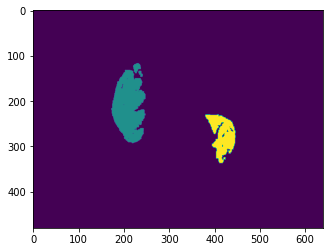

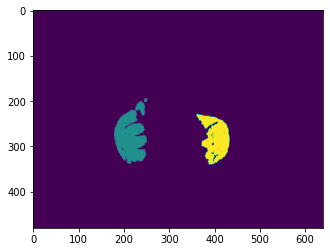

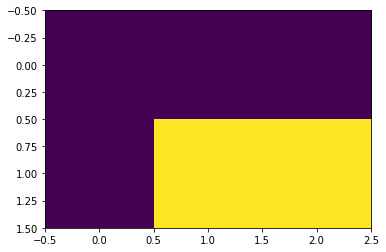

In [65]:
from keras.losses import categorical_crossentropy

gt = cv2.imread(handseg_path+'/masks/user-3.00025741.png')
pred = cv2.imread(handseg_path+'/masks/user-3.00025736.png')

mask = 1 - gt[:, :, 0]
gt = np.array(gt[:,:,0].astype('float32'))
pred = np.array(pred[:,:,0].astype('float32'))

y_true = np.array([[0, 1, 0], [0, 0, 1]])
print(y_true.shape, y_true.min(), y_true.max())
y_pred = np.array([[0.05, 0.95, 0], [0.1, 0.8, 0.1]])
mask = np.array([[0, 0, 0], [0, 1, 1]])

cce = tf.keras.losses.CategoricalCrossentropy() 
loss = cce(y_true, y_pred) * mask
print(loss)

print(gt.shape, gt.min(), gt.max())
print(mask.shape, mask.min(), mask.max())


plt.imshow(pred);plt.show()
plt.imshow(gt);plt.show()
plt.imshow(mask);plt.show()

In [6]:
# create the bounding boxes from the mask/prediction image
image_path = handseg_path+'/images/user-3.00025732.png'
mask_path = handseg_path+'/masks/user-3.00025732.png'

# Read color image
img = cv2.imread(image_path)

# Read mask; OpenCV can't handle indexed images, so we need Pillow here
# for that, see also: https://stackoverflow.com/q/59839709/11089932
mask = np.array(Image.open(mask_path))

# Iterate all colors in mask
for color in np.unique(mask):

    # Color 0 is assumed to be background or artifacts
    if color == 0:
        continue

    # Determine bounding rectangle w.r.t. all pixels of the mask with
    # the current color
    x, y, w, h = cv2.boundingRect(np.uint8(mask == color))

    # Draw bounding rectangle to color image
    out = cv2.rectangle(img.copy(), (x, y), (x+w, y+h), (0, int(color), 0), 2)

    # Show image with bounding box
    cv2.imshow('img_' + str(color), out)
    #plt.imshow(out); plt.title('img_' + str(color)); plt.show()
# Show mask
#plt.imshow(mask); plt.title('mask'); plt.show()
cv2.imshow('mask', mask)
cv2.waitKey(0)
cv2.destroyAllWindows()